In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import natsort
from TDB_functions import *
import importlib
#importlib.reload(TDB_functions)

import time
from numpy import linalg
from scipy.linalg import expm

plt.rcParams["font.family"] = "Times New Roman"
csfont = {'fontname':'Times New Roman'}

In [3]:

# # Set random seed for reproducibility
# np.random.seed(42)

# # Create a diagonal matrix with a wide range of negative eigenvalues
# eigenvalues = np.array([-1000, -900, -800, -700, -600, -500, -400, -300, -200, -100, -50, -25, -10, -5, -2, -1, -0.5, -0.1])
# L_matrix = np.diag(eigenvalues)

# # Add small random values to the off-diagonal elements
# L_matrix += np.random.uniform(-0.5, 0.5, size=(18, 18))

# # Ensure the matrix is full (no zero off-diagonal elements)
# L_matrix[L_matrix == np.diag(L_matrix)] = np.diag(L_matrix)

In [5]:
## Step 1: read Jacobian matrix 
read_L=np.loadtxt('./dataset/L_extract_275.dat')
L_matrix = np.reshape(read_L,(19,19))[0:-1,0:-1]  ## N2 is deleted


eigenvalues = np.linalg.eigvals(L_matrix)
print(np.max(abs(eigenvalues)))
print(2.785/np.max(abs(eigenvalues)))

3383400014.848043
8.231364863090483e-10


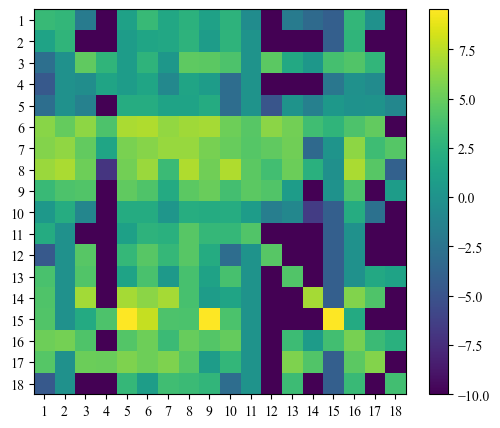

In [7]:
### Jacobian matrix looks like...

plt.figure(figsize=(6, 5))
plt.imshow(np.log10(abs(L_matrix)+1e-10), cmap='viridis', aspect='auto')
plt.colorbar().set_label(label='',size=18)

# Setting ticks
ticks = np.arange(18)
plt.xticks(ticks, ticks + 1)
plt.yticks(ticks, ticks + 1)

plt.show()

In [9]:
### Step 2: initial Phi matrix is read
#### Phi_init matrix is based on the 1-D cantera solution (# of grid points : 640).

n_vectors = 19
n_var = 18

init_name = './dataset/turb_flame.0000000.tec'
with open(init_name) as file1:
    __file = file1.readlines()[n_vectors+3:]    
    f_list = [float(i) for line in __file for i in line.split(' ') if i.strip()]
    numData = int(len(f_list)/n_vectors)
    init_temp = np.reshape(f_list,(numData,n_vectors), order='F')
print(numData)

## 4th index of init temp is Temperature, 
## 6th index of init temp is Pressure
### 11--28 indices of init temp are 
### H2, NH3, NO,  N2O, O2,  H, O, OH, HO2, H2O, H2O2,NO2, HNO, N, NNH, NH2, NH, H2NO

Phi_init = init_temp[:,1:]   ### 18 variables. row of Phi = # of grid points, column of Phi = # of species
spec = np.array(['H2','NH3','NO','N2O','O2','H','O','OH','HO2','H2O','H2O2','NO2','HNO','N','NNH','NH2','NH','H2NO'])
grid_1D = numData

640


In [321]:
####################################
#### User-specified parameter control
####################################

### grid size
ny = 1  #### To ensure the premise that n >> r +m, 1-D solution will be extrudced in the y-direction
        #### Thus, the total grid points (row of the matrix) will be 640 * ny 

### Monitoring control
i_time_mon = 1   ### frequency for monitoring values
monitor_index = 319 ### grid point index to be monitored
species_mon = 'H'  ### which species will be monitored
species_index = np.where(spec==species_mon)[0]

### TDB-CUR parameters
r = 12  ### rank
m = 20  ### number of over sampling points
fast_species = ['NNH']  ### fast species ( to be penalized)
######################################

rk_method =3 ### choose either 3 (=rk3) or 4 (rk4)

In [323]:
### erorr measurement

err_time = np.array([0])
err_norm = np.array([0])
tot_err_trial = 10

mult = 64

dt = 8e-10*mult ### time step size [s] 
tend = dt ### end time [s]

n_sub = mult

monitor_index = 319 ### center of the domain
species_index = 2

n_grid = grid_1D*ny 

analytic_ver2 = np.zeros((n_grid,n_var))

for i in range (0,640):
    analytic_ver2[i,:] = (Phi_init[i,:]@expm(L_matrix*tend))

    for i in range(0,ny):
        analytic_ver2[i*grid_1D:(i+1)*grid_1D,:] = analytic_ver2[0:640,:]
        
for tt in range (0,tot_err_trial):        
    if (tt >0):
        dt = dt/2    
        n_sub = max(int(n_sub/2),1)
    print( 'dt and n_sub are', dt, n_sub)
    tstep = int(tend/dt)
    i_time_mon = 1
    
    tstep = int(tend/dt)  ## total time steps
    
    dt_str = f"{dt:.1e}".replace('.', '_').replace('-', '_')
    Matrix_name = f"Phi_{dt_str}_{n_sub}"
    t_name = f"Time_{dt_str}_{n_sub}"
    
    bool_array = np.isin(spec, fast_species)
    fast_index = [i for species in fast_species for i, s in enumerate(spec) if s == species]
    globals()[t_name] = np.array([0])
    
    globals()[Matrix_name] = np.zeros(((n_grid,n_var,tstep+1)))
    
    for i in range(0,ny):
        globals()[Matrix_name][i*grid_1D:(i+1)*grid_1D,:,0] = Phi_init
    Sigma_temporal = np.zeros((n_var,tstep+1))
    
    truncatedSVD=TruncatedSVD(r)
    TDB_truncated = truncatedSVD.fit_transform(Phi_init)
    
    svd_U = TDB_truncated / truncatedSVD.singular_values_
    svd_U = svd_U / truncatedSVD.singular_values_   ### U 1
    
    Sigma_matrix = np.diag(truncatedSVD.singular_values_)
    VT = truncatedSVD.components_
    Sigma_temporal[:r,0] = truncatedSVD.singular_values_
    
    complete_p = set(range(n_grid))
    complete_s = set(range(n_var))
    
    G_p = np.zeros((r+m,n_var))
    G_s = np.zeros((n_grid,r))
    
    start_time = time.time()
    
    for t in range (0,tstep):
        ### Step 1: apply DEIM algorithm
        p_index = DEIM(svd_U, m)
        s_index = DEIM_penalty(VT.T,fast_index) 
        missing_p = list(complete_p - set(p_index))
        missing_s = list(complete_s - set(s_index))
        if (rk_method ==3):
            globals()[Matrix_name][:,:,t+1] = rk3_3_stage_subcycle_rev(globals()[Matrix_name][:,:,t], dt, L_matrix,n_sub, p_index,
                                               s_index, missing_p, missing_s)
        elif (rk_method==4):
            globals()[Matrix_name][:,:,t+1] = rk4_5_stage_subcycle_rev(globals()[Matrix_name][:,:,t], dt, L_matrix,n_sub, p_index,
                                               s_index, missing_p, missing_s)
        else:
            error ('you should choose either rk3 or rk4')

        ### Step 4: Intermediate step
        G_s = globals()[Matrix_name][:,s_index,t+1]
        G_p = globals()[Matrix_name][p_index,:,t+1]
        Q, _ = np.linalg.qr(G_s, mode='reduced')
        Z_matrix = (np.linalg.inv(Q[p_index,:].T @ Q[p_index,:]) @ Q[p_index,:].T @ G_p)
        
        truncatedSVD=TruncatedSVD(r)
        temp = truncatedSVD.fit_transform(Z_matrix)    
        temp = temp / truncatedSVD.singular_values_   ### U 1
        svd_U = Q @ temp     
        VT = truncatedSVD.components_
        Sigma_matrix = np.diag(truncatedSVD.singular_values_) ### Sigma
        Sigma_temporal[:r,t+1] = truncatedSVD.singular_values_
        globals()[Matrix_name][:,:,t+1] = svd_U @ Sigma_matrix @ VT
        
        globals()[t_name]=np.append(globals()[t_name],globals()[t_name][t]+dt*1e9)  ### conversion to ns
        if (t%i_time_mon ==0):
            print(f"{species_mon} is", globals()[Matrix_name][monitor_index,species_index,t+1], "\t", (t+1) ,"/", tstep, "\t unselected species are =", spec[missing_s])
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Elapsed time: {elapsed_time} seconds")
    print("You can post-process the data using these time and solution variables = ", t_name, Matrix_name)

    err_time = np.append(err_time,dt)
    err_norm = np.append(err_norm,linalg.norm(analytic_ver2[:,13] - globals()[Matrix_name][:,13,-1]))

dt and n_sub are 5.12e-08 64
H is 0.0010074696899888865 	 1 / 1 	 unselected species are = ['H' 'O' 'N' 'NNH' 'NH' 'H2NO']
Elapsed time: 0.302396297454834 seconds
You can post-process the data using these time and solution variables =  Time_5_1e_08_64 Phi_5_1e_08_64
dt and n_sub are 2.56e-08 32
H is 0.001008275477129537 	 1 / 2 	 unselected species are = ['H' 'O' 'N' 'NNH' 'NH' 'H2NO']
H is 0.0010078904206769434 	 2 / 2 	 unselected species are = ['H' 'O' 'N' 'NNH' 'NH' 'H2NO']
Elapsed time: 0.4204587936401367 seconds
You can post-process the data using these time and solution variables =  Time_2_6e_08_32 Phi_2_6e_08_32
dt and n_sub are 1.28e-08 16
H is 0.001008546160212594 	 1 / 4 	 unselected species are = ['H' 'O' 'N' 'NNH' 'NH' 'H2NO']
H is 0.001008317221234722 	 2 / 4 	 unselected species are = ['H' 'O' 'N' 'NNH' 'NH' 'H2NO']
H is 0.0010081262340974014 	 3 / 4 	 unselected species are = ['H' 'O' 'N' 'NNH' 'NH' 'H2NO']
H is 0.001007943623761566 	 4 / 4 	 unselected species are = ['

<>:57: SyntaxWarning: invalid escape sequence '\D'
<>:57: SyntaxWarning: invalid escape sequence '\D'
C:\Users\user\AppData\Local\Temp\ipykernel_5508\2283500547.py:57: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta t$',fontsize=19)


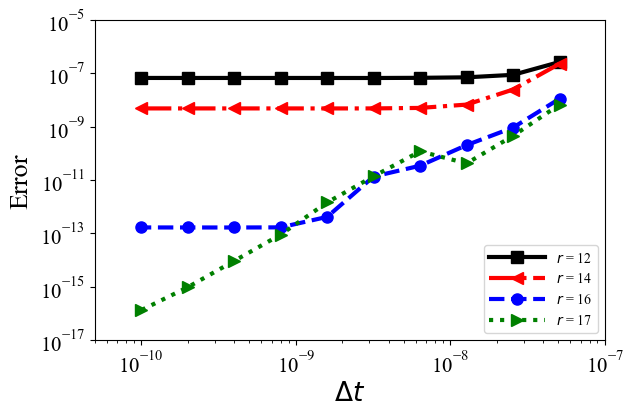

In [339]:
### monitor result

f1,ax = plt.subplots(1,1,figsize=(6,4))

### 1: ux, 4: T, 13: OH, 10: H, 24: CO2, 14: H2O, 46: N2O, 44: NO, 45: NO2
### 22: CH4, 9: H2, 12: O2, 61: N2
select = [4,15,20]
mark=['>','*','o','<','s']
### 1: ux, 4: T

# Define x values (logarithmic scale)

# Define y values with slope -4

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.15)

l=['-','-.','--',':','-','-.','--']
c=['black','red','blue','cyan','cyan']

offset = 25
offset3 = offset + 0

slope1= np.zeros(len(err_time[1:]))
slope4= np.zeros(len(err_time[1:]))

factor = np.zeros(len(err_time[1:]))
temporal_order1 = 1
temporal_order4 = 3

slope1[0] = err_norm[1]
slope4[0] = err_norm[1]

for i in range (0,len(slope1)):
    factor[i] = err_time[i+1]/err_time[1]
    slope1[i] = err_norm[1]*(factor[i])**temporal_order1
    slope4[i] = err_norm[1]*(factor[i])**temporal_order4

ax.plot(err_time[1:],r12[1:],color='black',linewidth=3,linestyle=l[0],marker='s',markersize=8)              
ax.plot(err_time[1:],r14[1:],color='red',linewidth=3,linestyle=l[1],marker='<',markersize=8)              
ax.plot(err_time[1:],r16[1:],color='blue',linewidth=3,linestyle=l[2],marker='o',markersize=8)              
ax.plot(err_time[1:],r17[1:],color='green',linewidth=3,linestyle=l[3],marker='>',markersize=8)              
     
ax.legend(['$r$ = 12','$r$ = 14','$r$ = 16','$r$ = 17'],handlelength=4)

#ax.plot(err_time[1:],slope4,color='black',linewidth=2,linestyle=l[0])        

#ax.plot(err_time[1:],err_norm_17[1:],color='red',linewidth=3,linestyle=l[0],marker='o')        

ax.set_xlim(5e-11,1e-7)
ax.set_ylim(1e-17,1e-5)
#ax.set_xlim(-5e-8*1e9,1.0e-7*1e9)
ax.set_xlabel('$\Delta t$',fontsize=19)
ax.set_ylabel('Error',fontsize=19)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both',labelsize = 15)
ax.xaxis.get_offset_text().set_fontsize(15)    

plt.savefig('./Error_analysis.png',format='png', dpi=1000,bbox_inches = "tight")           

In [397]:


### TDB-CUR starts
r=16
### Time step control
tlim_FOM = 8e-10 ### 2.785 /largest eigenvalue. FOM is limited by this dt [s]
dt = tlim_FOM*32  ### time step size for TDB [s]  
n_sub = int(dt/tlim_FOM)  ### number of sub-cycle steps. multiplied by 2 to ensure that n_sub is large enough
tend = 1e-05  ### end time [s]

n_grid = grid_1D*ny 
tstep = int(tend/dt)  ## total time steps

dt_str = f"{dt:.1e}".replace('.', '_').replace('-', '_')
Matrix_name = f"Phi_{dt_str}_{n_sub}"
t_name = f"Time_{dt_str}_{n_sub}"

bool_array = np.isin(spec, fast_species)
fast_index = [i for species in fast_species for i, s in enumerate(spec) if s == species]
globals()[t_name] = np.array([0])

globals()[Matrix_name] = np.zeros(((n_grid,n_var,tstep+1)))
analytic = np.zeros(((n_grid,n_var,tstep+1)))

for i in range(0,ny):
    globals()[Matrix_name][i*grid_1D:(i+1)*grid_1D,:,0] = Phi_init
Sigma_temporal = np.zeros((n_var,tstep+1))

for i in range (0,n_grid):
    analytic[i,:,0] = (Phi_init[i,:]@expm(L_matrix*0))

truncatedSVD=TruncatedSVD(r)
TDB_truncated = truncatedSVD.fit_transform(Phi_init)

svd_U = TDB_truncated / truncatedSVD.singular_values_
svd_U = svd_U / truncatedSVD.singular_values_   ### U 1

Sigma_matrix = np.diag(truncatedSVD.singular_values_)
VT = truncatedSVD.components_
Sigma_temporal[:r,0] = truncatedSVD.singular_values_

complete_p = set(range(n_grid))
complete_s = set(range(n_var))

G_p = np.zeros((r+m,n_var))
G_s = np.zeros((n_grid,r))

start_time = time.time()

for t in range (0,tstep):
    ### Step 1: apply DEIM algorithm
    p_index = DEIM(svd_U, m)
    s_index = DEIM_penalty(VT.T,fast_index) 
    missing_p = list(complete_p - set(p_index))
    missing_s = list(complete_s - set(s_index))

    for i in range (0,n_grid):
        analytic[i,:,t+1] = (Phi_init[i,:]@expm(L_matrix*dt*(t+1)))
    
    if (rk_method ==3):
        globals()[Matrix_name][:,:,t+1] = rk3_3_stage_subcycle_rev(globals()[Matrix_name][:,:,t], dt, L_matrix,n_sub, p_index,
                                           s_index, missing_p, missing_s)
    elif (rk_method==4):
        globals()[Matrix_name][:,:,t+1] = rk4_5_stage_subcycle_rev(globals()[Matrix_name][:,:,t], dt, L_matrix,n_sub, p_index,
                                           s_index, missing_p, missing_s)
    else:
        error ('you should choose either rk3 or rk4')

    ### Step 4: Intermediate step
    G_s = globals()[Matrix_name][:,s_index,t+1]
    G_p = globals()[Matrix_name][p_index,:,t+1]
    Q, _ = np.linalg.qr(G_s, mode='reduced')
    Z_matrix = (np.linalg.inv(Q[p_index,:].T @ Q[p_index,:]) @ Q[p_index,:].T @ G_p)
    
    truncatedSVD=TruncatedSVD(r)
    temp = truncatedSVD.fit_transform(Z_matrix)    
    temp = temp / truncatedSVD.singular_values_   ### U 1
    svd_U = Q @ temp     
    VT = truncatedSVD.components_
    Sigma_matrix = np.diag(truncatedSVD.singular_values_) ### Sigma
    Sigma_temporal[:r,t+1] = truncatedSVD.singular_values_
    globals()[Matrix_name][:,:,t+1] = svd_U @ Sigma_matrix @ VT
    
    globals()[t_name]=np.append(globals()[t_name],globals()[t_name][t]+dt*1e9)  ### conversion to ns
    if (t%i_time_mon ==0):
        print(f"{species_mon} is", globals()[Matrix_name][monitor_index,species_index,t+1], "\t", (t+1) ,"/", tstep, "\t unselected species are =", spec[missing_s])

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print("You can post-process the data using these time and solution variables = ", t_name, Matrix_name)

H is 0.0010083241853777202 	 1 / 390 	 unselected species are = ['H' 'NNH']
H is 0.00100794241415399 	 2 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0010075230125512404 	 3 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0010069805205203592 	 4 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0010062908661708002 	 5 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0010054591886581746 	 6 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0010045027531077162 	 7 / 390 	 unselected species are = ['H' 'NNH']
H is 0.001003442247027033 	 8 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0010022975300973769 	 9 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0010010865724817098 	 10 / 390 	 unselected species are = ['H' 'NNH']
H is 0.000999823517241132 	 11 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0009985205162066618 	 12 / 390 	 unselected species are = ['H' 'NNH']
H is 0.0009971867021532814 	 13 / 390 	 unselected species are = ['H' 'NNH']
H is 0.00099

In [505]:
####################################
# post-processing user parameters
####################################

post_species = ['NNH']  ### species to be plotted
skip = 10   ### number of skips for plot TDB-CUR results
post_grid_point = 319 

In [507]:
post_index = [i for species in post_species for i, s in enumerate(spec) if s == species]

print(post_index)

[14]


In [509]:
32*8e-10*1e9

25.6

In [511]:
### Step 0: read FOM solutions

FOM_time = np.load('./results/FOM_time.npy')
FOM_solution = np.load('./results/FOM_solution.npy')
FOM_sigular = np.load('./results/FOM_singular.npy')

FOM_time_16ns = np.load('./results/FOM_16ns_time.npy')
FOM_solution_16ns = np.load('./results/FOM_16ns_solution.npy')

<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
C:\Users\user\AppData\Local\Temp\ipykernel_5508\3174898260.py:34: SyntaxWarning: invalid escape sequence '\D'
  ax.legend(['Analytic solution','TDB-CUR ($r$ = 16, $\Delta t$ = 25.6 ns)','DNS ($\Delta t$ = 0.8 ns)','DNS ($\Delta t$ = 1.6 ns; diverges)'],handlelength=3)
C:\Users\user\AppData\Local\Temp\ipykernel_5508\3174898260.py:34: SyntaxWarning: invalid escape sequence '\D'
  ax.legend(['Analytic solution','TDB-CUR ($r$ = 16, $\Delta t$ = 25.6 ns)','DNS ($\Delta t$ = 0.8 ns)','DNS ($\Delta t$ = 1.6 ns; diverges)'],handlelength=3)
C:\Users\user\AppData\Local\Temp\ipykernel_5508\3174898260.py:34: SyntaxWarning: invalid escape sequence '\D'
  ax.legend(['Analytic solution','TDB-CUR ($r$

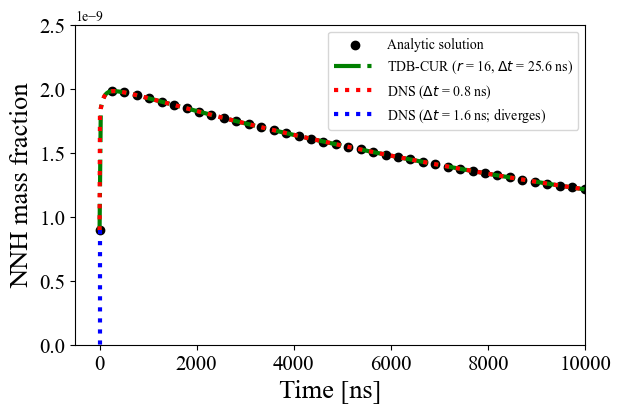

In [513]:
### post-processings

post_index = [i for species in post_species for i, s in enumerate(spec) if s == species]
len_post = len(post_index)

f1,ax = plt.subplots(len_post,1,figsize=(6,4*len_post))

mark=['>','*','o','<','s']
### 1: ux, 4: T

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)

l=['-','-.','--',':','-','-.','--']
c=['black','red','blue','cyan','cyan']

if (len_post ==1):
    ax.scatter(globals()[t_name][::skip],analytic[post_grid_point,post_index[0],::skip],color='black')                                

    ax.plot(globals()[t_name][:],globals()[Matrix_name][post_grid_point,post_index[0],:],color='green',linewidth=3,linestyle=l[1])                                
    ax.plot(FOM_time,FOM_solution[post_grid_point,post_index[0],:],color='red',linewidth=3,linestyle=l[3])                                
    ax.plot(FOM_time_16ns,FOM_solution_16ns[post_grid_point,post_index[0],:],color='blue',linewidth=3,linestyle=l[3])         

    ax.set_xlabel('Time [ns]',fontsize=19)
    ax.set_ylabel(f'{post_species[0]} mass fraction',fontsize=19)
    ax.tick_params(axis='both',labelsize = 15)
    ax.xaxis.get_offset_text().set_fontsize(15)
    ax.set_xlim(-500,10000)
    ax.set_ylim(0,2.5e-9)
    ax.legend(['Analytic solution','TDB-CUR ($r$ = 16, $\Delta t$ = 25.6 ns)','DNS ($\Delta t$ = 0.8 ns)','DNS ($\Delta t$ = 1.6 ns; diverges)'],handlelength=3)

else:
    error('should be updated')

plt.savefig('./NNH_temporal.png',format='png', dpi=1000,bbox_inches = "tight")           

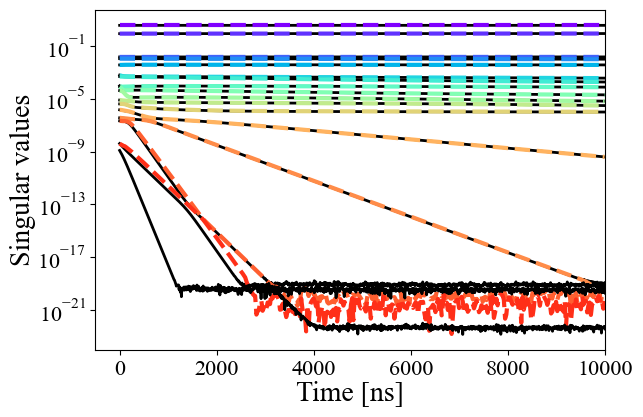

In [515]:
from matplotlib.pyplot import cm


fig, ax = plt.subplots(1,1,figsize=(6,4))

skip=1
rank=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
color = iter(cm.rainbow(np.linspace(0, 1, len(rank))))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.2,
                    hspace=0.1)

for i in range (0,len(rank)):
    c = next(color)        
    ax.plot(FOM_time[:],FOM_sigular[int(rank[i]-1),:],color='black',linewidth=2,alpha=1)
    ax.plot(globals()[t_name][::skip],Sigma_temporal[int(rank[i]-1),::skip],color=c,linestyle='--',linewidth=3)

ax.set_xlim(-5e-8*1e9,1.0e-5*1e9)

ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xlim(-500,10000)

ax.set_xlabel("Time [ns]",labelpad=1,fontsize =20)
ax.set_ylabel("Singular values",labelpad=1,fontsize =20)

ax.tick_params(axis='both',labelsize = 16)    
plt.savefig('./singular_values.png',format='png', dpi=1000,bbox_inches = "tight")           